In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 ## only use 50 % of the gpu
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###  Importing  Necessary Library

In [8]:
import numpy as np
from glob import glob
from tensorflow.keras.layers import (Input, Lambda, Dense, Flatten)
from tensorflow.keras.models import (Model, Sequential)
from tensorflow.keras.applications.mobilenet_v2 import (MobileNetV2, preprocess_input)
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, load_img, array_to_img, img_to_array)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [9]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/dataset/train'
valid_path = '/content/drive/MyDrive/dataset/val'
test_path =  '/content/drive/MyDrive/dataset/test'

In [10]:
# Import the MobileNet library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

mobile_net  = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [73]:
print("No Of The Layer In MObileNet :--> ", len(mobile_net.layers))

No Of The Layer In MObileNet :-->  154


In [74]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/dataset/train/*')
print("total no of the folder in the train dataset :-->", len(folders))


total no of the folder in the train dataset :--> 100


In [75]:
###  Data Preprocessing

In [131]:
# Use the Image Data Generator to import the images from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to the range [0, 1]
    preprocessing_function=preprocess_input,
    rotation_range=40,         # Randomly rotate images by up to 40 degrees
    width_shift_range=0.3,     # Randomly shift images horizontally by up to 30% of the width
    height_shift_range=0.3,    # Randomly shift images vertically by up to 30% of the height
    shear_range=0.3,           # Shear intensity
    zoom_range=0.3,            # Randomly zoom images by up to 30%
    horizontal_flip=True,      # Randomly flip images horizontally
    vertical_flip=True,        # Randomly flip images vertically
    brightness_range=[0.6, 1.4],  # Randomly adjust brightness
    channel_shift_range=100.0,  # Randomly shift channels
    fill_mode='nearest',       # Strategy for filling in newly created pixels
    validation_split=0.2       # Fraction of training data to use for validation
)

test_datagen = ImageDataGenerator(rescale=1./255,   # Rescale pixel values for the test set
                                  preprocessing_function=preprocess_input)



In [132]:
# Make sure to provide the same target size as initialied for the image size

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1200 images belonging to 100 classes.
Found 400 images belonging to 100 classes.


In [133]:
print("LIST OF THE CLASS NAME  ARE :-", list(training_set.class_indices.keys()))

LIST OF THE CLASS NAME  ARE :- ['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [134]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobile_net.layers))

# Fine-tune from this layer onwards
fine_tune_at = 110

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobile_net.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [135]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#learning_rate reduce module
lr_reduce = ReduceLROnPlateau('val_loss', patience=4,
                                              factor=0.5, min_lr=1e-6)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=4,
                              verbose=0, restore_best_weights=True)

In [136]:
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.layers import BatchNormalization

# Define a more complex Sequential model
model = Sequential()

# Add MobileNetV2 base model
model.add(mobile_net)

# Add additional convolutional block with leaky ReLU activation and batch normalization
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU with alpha=0.1
model.add(BatchNormalization())  # Batch normalization
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add Dropout layer
model.add(Dropout(0.5))  # Example: dropout rate of 0.5

# Add fully connected layers with leaky ReLU activation and batch normalization
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU with alpha=0.1
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.5))  # Example: dropout rate of 0.5
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU with alpha=0.1
model.add(BatchNormalization())  # Batch normalization

# Output layer
model.add(Dense(len(folders), activation='softmax'))



In [137]:
import tensorflow as tensorflow

# Define hyperparameters
learning_rate = 0.001
dropout_rate = 0.5
batch_size = 32

# Choose optimizer
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [138]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 64)          737344    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 5, 5, 64)          0         
                                                                 
 batch_normalization_9 (Bat  (None, 5, 5, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                     

In [139]:
history_fine = model.fit(training_set,
                         batch_size = 32,
                         epochs=500,
                         validation_data=validation_set,
                         callbacks=[lr_reduce, early_stopper],
                         verbose=1, shuffle=True)

Epoch 1/500
38/38 [==============================] - 34s 653ms/step - loss: 5.2236 - accuracy: 0.0117 - val_loss: 9.7434 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 2/500
38/38 [==============================] - 24s 638ms/step - loss: 5.1483 - accuracy: 0.0108 - val_loss: 9.3266 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 3/500
38/38 [==============================] - 23s 591ms/step - loss: 5.0928 - accuracy: 0.0075 - val_loss: 6.1608 - val_accuracy: 0.0125 - lr: 0.0010
Epoch 4/500
38/38 [==============================] - 23s 611ms/step - loss: 5.0042 - accuracy: 0.0083 - val_loss: 7.0427 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 5/500
38/38 [==============================] - 23s 618ms/step - loss: 4.9229 - accuracy: 0.0117 - val_loss: 6.7668 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 6/500
38/38 [==============================] - 23s 614ms/step - loss: 4.8811 - accuracy: 0.0092 - val_loss: 6.5909 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 7/500
38/38 [==============================] - 24s 6

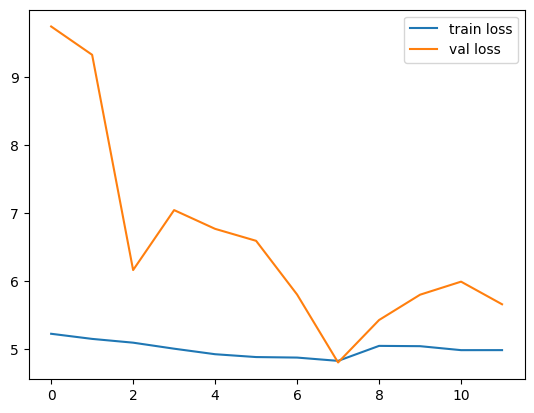

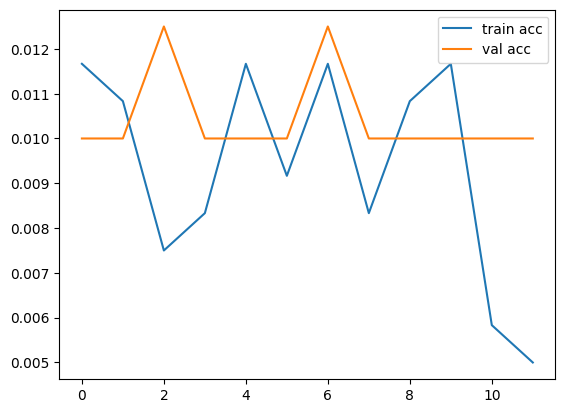

<Figure size 640x480 with 0 Axes>

In [140]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history_fine.history['accuracy'], label='train acc')
plt.plot(history_fine.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [141]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('MobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [142]:
y_pred = np.argmax(model.predict(validation_set), axis =1)

13/13 [==============================] - 2s 115ms/step


In [112]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model2=load_model('MobileNet.h5')

In [123]:
img=image.load_img('/content/drive/MyDrive/dataset/test/100/image_1.png',target_size=(224,224))


In [125]:
x=image.img_to_array(img)
x=x/255

In [126]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [127]:
model.predict(img_data)


1/1 [==============================] - 0s 25ms/step


array([[1.8449273e-02, 1.9731641e-02, 2.5392696e-01, 5.4955683e-03,
        4.8359274e-03, 2.0809560e-03, 1.7177215e-03, 4.5483978e-03,
        1.2287199e-03, 1.9255003e-03, 3.1432528e-03, 9.6178604e-03,
        1.0929066e-02, 3.9484072e-03, 5.9148367e-03, 1.8310986e-02,
        2.4644982e-05, 3.3932589e-02, 9.6146564e-04, 7.8455068e-04,
        6.6700735e-04, 3.9574737e-03, 6.2834010e-03, 2.7570659e-03,
        3.4977272e-02, 1.6611671e-03, 1.0675493e-02, 1.0265244e-02,
        6.4532366e-04, 8.6605605e-03, 1.8767348e-03, 2.0903956e-02,
        1.9829881e-03, 1.4890585e-03, 1.7768629e-03, 3.3471896e-03,
        7.1649021e-03, 1.1069099e-03, 6.5885775e-04, 4.7181509e-02,
        1.5602109e-03, 6.2668957e-03, 2.3291667e-03, 1.4621777e-03,
        7.3006973e-03, 9.8342041e-04, 8.5210185e-03, 5.7182489e-03,
        1.3498288e-02, 2.9064252e-03, 9.5684960e-04, 1.5876566e-04,
        1.0826608e-02, 7.2883539e-02, 4.0667947e-02, 2.0504256e-03,
        1.6038938e-03, 8.3495304e-03, 1.2892905e

In [128]:
a=np.argmax(model.predict(img_data), axis=1)
a

1/1 [==============================] - 0s 21ms/step


array([2])